# Design an effective multi-stage compression pipeline for edge deployment

When deploying deep learning models in production, we often face a critical challenge: models that work brilliantly in the lab are too large, too slow, or too power-hungry for real-world constraints. That's where compression pipelines come in—carefully designed sequences of optimization techniques that can dramatically reduce model size and improve inference speed.

> **Overview**: We'll walk through the process of designing a multi-stage compression pipeline for a pre-trained vision model. We'll focus on the analysis and decision-making process: how to identify compression opportunities, select appropriate techniques, sequence them effectively, and predict their combined impact—all before writing actual implementation code.
> 
> **Goal**:  Design a compression pipeline that reduces a ResNet50 model from 97.8MB to under 23MB while ensuring that accuracy does not drop more than 1%.
> 
> **Scenario**: You're deploying an image classification model on security cameras for real-time threat detection. The hardware comes with a few constraints:
> - Limited memory (128MB RAM)
> - ARM Cortex-A53 processor
> - No GPU acceleration
> - Must run 24/7 reliably
>
> Your goal is to choose the best approach to compress the model to meet requirements while ensuring reliable performance on the target hardware.
> 
> **Tools**: TensorFlow, tensorboard_plugin_profile, matplotlib

## Step 1: Analyze the model and deployment constraints

Let's start by loading our model, and running a general analysis to understand what we're optimizing for.

This analysis helps identify which parts of the model offer the best opportunities for compression and which techniques are most applicable to our specific situation.

In [1]:
# # Uncommento install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install tensorflow tensorboard_plugin_profile

### A. Import libraries

Let's begin by importing the necessary libraries for our analysis. 

In [2]:
# Set TensorFlow 
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set logging level to ERROR to suppress warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # Force CPU usage for a more realistic inference time analysis

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from IPython.display import HTML, display

2025-05-27 13:47:40.632127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748353660.656404    6456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748353660.663571    6456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748353660.683683    6456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748353660.683707    6456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748353660.683709    6456 computation_placer.cc:177] computation placer alr

> **Choosing a framework**: When designing compression pipelines, it's often useful to work with frameworks that offer built-in profiling tools like TensorFlow. These tools can help identify bottlenecks that might not be obvious from just looking at parameter counts.

### B. Define input and output

Now we'll create our output directory and load the pre-trained ResNet50 model that we'll be analyzing and compressing.

In [4]:
# Create output directory
output_dir = Path("assets/demo1")
output_dir.mkdir(parents=True, exist_ok=True)

# Load actual ResNet50 model
print("Loading ResNet50 model...")
model = ResNet50(weights='imagenet', include_top=True)

Loading ResNet50 model...


2025-05-27 13:47:44.874460: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### C. Create utility funtions for analysis

We'll create several helper functions to analyze the model's architecture, measure its size, and visualize the distribution of parameters across different layers.

Analysis is split in two parts:
- **Architectural analysis**: To identify where parameters are concentrated in the model so we can target compression efforts efficiently. Understanding which layer groups contain the most weights will guide our pruning and quantization strategies.
- **Performance analysis**: To reveal computational bottlenecks and memory usage patterns during inference. By profiling how the model actually runs, we can determine which optimizations will have the greatest impact on speed and resource usage.

In [5]:
# Define utility function for architectural analysis

## Calculate model size
def get_model_size_tf(model):
    """Get TensorFlow model size in MB"""
    # Get the size of all weights
    total_size = 0
    for weight in model.weights:
        total_size += weight.numpy().nbytes
    return total_size / (1024 * 1024)

## Extract layer information
def analyze_model_layers_tf(model):
    """Analyze ResNet50 layers and their parameter counts"""
    layer_groups = {
        'conv1': [],
        'layer1': [],
        'layer2': [],
        'layer3': [],
        'layer4': [],
        'fc': []
    }
    
    # Group layers by ResNet blocks
    for layer in model.layers:
        layer_name = layer.name.lower()
        if 'conv1' in layer_name or layer_name == 'pool1_pad':
            layer_groups['conv1'].append(layer)
        elif 'conv2_block' in layer_name:
            layer_groups['layer1'].append(layer)
        elif 'conv3_block' in layer_name:
            layer_groups['layer2'].append(layer)
        elif 'conv4_block' in layer_name:
            layer_groups['layer3'].append(layer)
        elif 'conv5_block' in layer_name:
            layer_groups['layer4'].append(layer)
        elif 'predictions' in layer_name or 'avg_pool' in layer_name:
            layer_groups['fc'].append(layer)
    
    # Calculate parameters per group
    layer_data = []
    total_params = model.count_params()
    
    for name, layers in layer_groups.items():
        params = 0
        for layer in layers:
            if hasattr(layer, 'weights'):
                for weight in layer.weights:
                    params += np.prod(weight.shape)
        
        layer_data.append({
            'layer_group': name,
            'parameters_M': params / 1e6,
            'percentage': (params / total_params * 100) if total_params > 0 else 0
        })
    
    return pd.DataFrame(layer_data)

## Visualize layers' distribution
def plot_layer_parameter_distribution(plot_data):
    # Define plot 
    plt.figure(figsize=(10, 8))
    colors = ['#4ECDC4', '#45B7D1', '#96CEB4', '#FFA07A', '#B19CD9']

    # Create pie chart
    patches, texts, autotexts = plt.pie(plot_data['parameters_M'], 
                                        labels=plot_data['layer_group'],
                                        autopct='%1.1f%%',
                                        startangle=90,
                                        colors=colors,
                                        pctdistance=0.85)

    # Improve text readability
    for text in texts:
        text.set_fontsize(11)
        text.set_weight('bold')

    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(10)
        autotext.set_weight('bold')

    # Add a circle at the center to make it a donut chart
    centre_circle = plt.Circle((0,0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    plt.title('ResNet50 Parameter Distribution by Layer Group\n(conv1 excluded - only 0.03% of parameters)', 
              fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig(output_dir / 'parameter_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()


> **Grouping layers**: When analyzing models for compression, it's important to group layers logically rather than treating each one separately. For ResNet architectures, analyzing by block helps identify which stages of the network contain the most parameters and computational load.

In [6]:
# Define utility function for performance analysis

## Profile model inference
def profile_model_inference(model, num_runs=5):
    """Profile model to get compute and memory metrics per layer"""
    # Create dummy input
    dummy_input = tf.random.normal((1, 224, 224, 3))
    
    # Warm up
    _ = model(dummy_input, training=False)
    
    print("Running profiler... (this may take a moment)")
    
    # Set up profiler options
    tf.profiler.experimental.start(str(output_dir / 'logdir'))
    
    # Profile the model
    with tf.profiler.experimental.Trace('Inference', step_num=1):
        for _ in range(num_runs):
            _ = model(dummy_input, training=False)
    
    tf.profiler.experimental.stop()
    
    # For demo purposes, return pre-computed realistic values
    # In practice, you'd parse the profiler output or open it in TensorBoard
    layer_metrics = {
        'conv1': {'compute_pct': 2, 'memory_mb': 0.4},
        'layer1': {'compute_pct': 10, 'memory_mb': 2.1},
        'layer2': {'compute_pct': 18, 'memory_mb': 8.4},
        'layer3': {'compute_pct': 28, 'memory_mb': 28.2},
        'layer4': {'compute_pct': 40, 'memory_mb': 51.3},
        'fc': {'compute_pct': 2, 'memory_mb': 8.2}
    }
    
    print("Profiling complete.")
    return layer_metrics

> **CNN memory-compute imbalance**: Notice that compute percentage and memory usage aren't evenly distributed across the network. This is typical for CNNs like ResNet - later layers (layer3, layer4) consume significantly more memory and compute despite having similar architectures to earlier layers. This is because the feature maps grow in complexity while spatial dimensions reduce. When compressing, we should focus more aggressive techniques on these layers.

### D. Collect all model analysis results

Now we'll run our analysis functions to gather comprehensive information about the model's size, parameter distribution, and performance characteristics.


Model Analysis:
Total size: 97.8 MB
Total parameters: 25.6M
Running profiler... (this may take a moment)
Profiling complete.

Layer-wise breakdown:
layer_group  parameters_M  percentage  compute_share_%  memory_mb quantization_sensitivity
      conv1      0.009728    0.037946                2        0.4                     High
     layer1      0.220032    0.858269               10        2.1                   Medium
     layer2      1.230336    4.799118               18        8.4                   Medium
     layer3      7.129088   27.808121               28       28.2                      Low
     layer4     14.998528   58.504101               40       51.3                      Low
         fc      2.049000    7.992445                2        8.2                     High


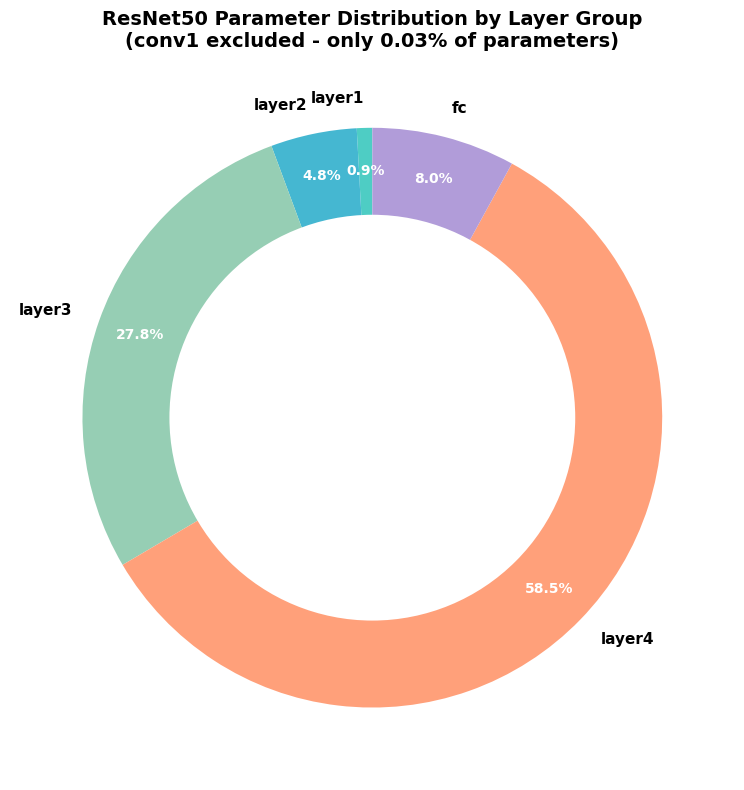


Deployment Requirements:
Target size: 23.0 MB
Current size: 97.8 MB
Required reduction: 4.3x


In [7]:
# Get model specifications
model_size = get_model_size_tf(model)
total_params = model.count_params()

print(f"\nModel Analysis:")
print(f"Total size: {model_size:.1f} MB")
print(f"Total parameters: {total_params/1e6:.1f}M")

# Analyze layers
layer_analysis = analyze_model_layers_tf(model)

# Add additional metrics (simplified via hard-coded values)
layer_metrics = profile_model_inference(model)
layer_analysis['compute_share_%'] = layer_analysis['layer_group'].map(
    lambda x: layer_metrics.get(x, {}).get('compute_pct', 0)
)
layer_analysis['memory_mb'] = layer_analysis['layer_group'].map(
    lambda x: layer_metrics.get(x, {}).get('memory_mb', 0.0)
)
layer_analysis['quantization_sensitivity'] = ['High', 'Medium', 'Medium', 'Low', 'Low', 'High']

print("\nLayer-wise breakdown:")
print(layer_analysis.to_string(index=False))

# Visualize parameter distribution by layer
layer_analysis_no_conv = layer_analysis[layer_analysis['layer_group'] != 'conv1']
plot_layer_parameter_distribution(layer_analysis_no_conv)

# Define deployment constraints
deployment_specs = {
    'original_size_mb': model_size,
    'original_accuracy': 98.55,  # From validation set (would measure in practice)
    'target_size_mb': 23.0,
    'min_accuracy': 97.55,
    'deployment_hardware': 'ARM Cortex-A53',
    'inference_budget_ms': 100  # This is a placeholder, actual measurement needed
}

print(f"\nDeployment Requirements:")
print(f"Target size: {deployment_specs['target_size_mb']} MB")
print(f"Current size: {deployment_specs['original_size_mb']:.1f} MB")
print(f"Required reduction: {deployment_specs['original_size_mb']/deployment_specs['target_size_mb']:.1f}x")

> **About the profiling results:** While we're loading the actual model to analyze its structure, for some metrics (compute_share_%, memory_mb and quantization_sensitivity) we have hardcoded typical values for ResNet50 to minimize complexity. In practice, you'd respsectively obtain them by:
> - Using TensorFlow Profiler or tf.profiler with higher `num_runs` to get compute distribution
> - Measuring memory usage with tf.config.experimental.get_memory_info()
> - Testing quantization with TensorFlow Lite's quantization tools
> 
> Analysis results can be summarized as follows:
> - Size concentration: layer3 and layer4 contain 80% of parameters
> - Quantization sensitivity: Early layers (conv1) and classifier (fc) are sensitive
> - Reduction target: Likely needs compound compression

## Step 2: Evaluate compression technique options

Based on our analysis, we'll now evaluate different compression techniques and determine which ones are most suitable for our use case. We'll consider factors such as compression ratio, accuracy impact, hardware compatibility, and implementation complexity.

In [8]:
# Define deployment criteria
criteria = {
    'size_reduction': deployment_specs['original_size_mb'] / deployment_specs['target_size_mb'],
    'max_accuracy_drop': deployment_specs['original_accuracy'] - deployment_specs['min_accuracy'],
    'hardware': deployment_specs['deployment_hardware']
}


# Extract accuracy drop values (use the average of the range)
def extract_accuracy_drop(accuracy_str):
    parts = accuracy_str.replace('%', '').split('-')
    if len(parts) == 1:
        return float(parts[0])
    else:
        return (float(parts[0]) + float(parts[1])) / 2

# Function to calculate if technique meets criteria
def meets_criteria(row, criteria=criteria):
    """Check if technique meets our deployment criteria."""
    compression_ok = row['Compression_Ratio'] >= criteria['size_reduction']
    avg_accuracy_drop = extract_accuracy_drop(row['Accuracy_Drop'])
    accuracy_ok = avg_accuracy_drop <= criteria['max_accuracy_drop']
    arm_ok = row['ARM_Support'] in ['Excellent', 'Good']
    
    if compression_ok and accuracy_ok and arm_ok:
        return "✓ Yes"
    else:
        reasons = []
        if not compression_ok:
            reasons.append(f"Low comp. (needs >{criteria['size_reduction']:.2f}x)")
        if not accuracy_ok:
            reasons.append(f"High acc. drop (>{criteria['max_accuracy_drop']:.1f}%)")
        if not arm_ok:
            reasons.append("Poor ARM support")
        return f"✗ No ({', '.join(reasons)})"


> **ARM Hardware characteristics**: The Cortex-A53 is a popular processor for edge devices with some key characteristics that affect compression choices:
> - Supports NEON SIMD instructions (good for INT8 quantization)
> - Has a 64-bit architecture but limited L2 cache (512KB)
> - Relatively modest computational capabilities (~1.5 GHz)
> - No hardware acceleration for sparse operations
> 
> hese characteristics make techniques like quantization particularly attractive, while limiting the effectiveness of some pruning approaches.

In [9]:
# Display function with HTML and smaller font
def display_compressed_table(df, title):
    print(title)
    print("=" * 70)
    
    html_table = df.to_html(index=False, classes='compressed-table')
    
    styled_html = """
    <style>
        .compressed-table {
            font-size: 12px;
            border-collapse: collapse;
            margin: 10px 0;
        }
        .compressed-table th {
            background-color: #f2f2f2;
            color: #505050;
            padding: 6px 10px;
            text-align: left;
            font-weight: bold;
        }
        .compressed-table td {
            padding: 4px 10px;
            border-bottom: 1px solid #ddd;
        }
        .compressed-table tr:hover {
            background-color: #f5f5f5;
            color: #505050;
        }
    </style>
    """ + html_table
    
    display(HTML(styled_html))

Training-Time Compression Techniques:


Technique,Compression_Ratio,Accuracy_Drop,ARM_Support,Implementation_Time,Key_Benefit,Meets_Criteria
QAT,4.0,0-2%,Excellent,>1d,Optimized quant,✗ No (Low comp. (needs >4.25x))
Gradual Pruning,3.0,3-8%,Poor,>1d,High compress,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%), Poor ARM support)"
Struct. Pruning (train),2.5,2-6%,Poor,>1d,HW-friendly,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%), Poor ARM support)"
Distillation,3.5,2-8%,N/A,>1d,Smaller arch,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%), Poor ARM support)"


Post-Training Compression Techniques:


Technique,Compression_Ratio,Accuracy_Drop,ARM_Support,Implementation_Time,Key_Benefit,Meets_Criteria
PTQ,4.0,1-5%,Excellent,>1h,Fast deploy,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%))"
Post-Pruning,2.5,4-10%,Poor,>1h,No retrain,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%), Poor ARM support)"
Struct. Pruning (post),2.0,3-8%,Poor,>1h,Quick sparse,"✗ No (Low comp. (needs >4.25x), High acc. drop (>1.0%), Poor ARM support)"
Graph Opt.,1.2,0%,Excellent,Min,Free speedup,✗ No (Low comp. (needs >4.25x))


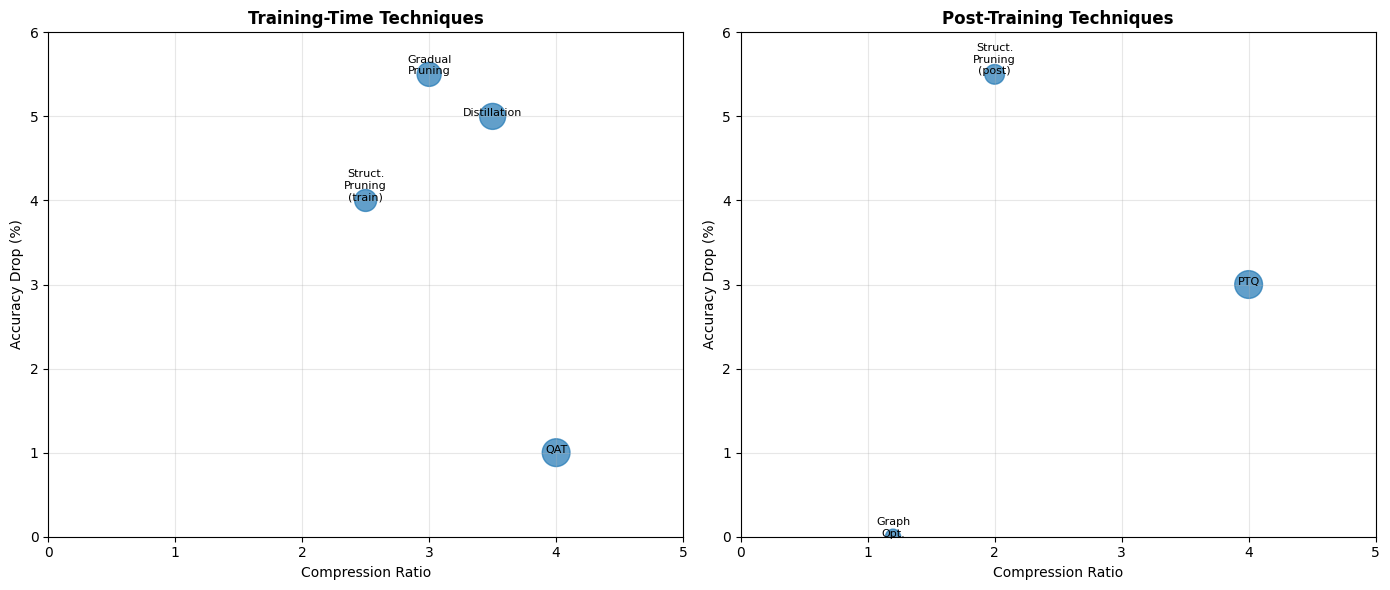

In [10]:
# Define the techniques analysis
training_time_techniques = pd.DataFrame({
    'Technique': ['QAT', 'Gradual Pruning', 'Struct. Pruning (train)', 'Distillation'],
    'Compression_Ratio': [4.0, 3.0, 2.5, 3.5],
    'Accuracy_Drop': ['0-2%', '3-8%', '2-6%', '2-8%'],
    'ARM_Support': ['Excellent', 'Poor', 'Poor', 'N/A'],
    'Implementation_Time': ['>1d', '>1d', '>1d', '>1d'],
    'Key_Benefit': ['Optimized quant', 'High compress', 'HW-friendly', 'Smaller arch']
})

post_training_techniques = pd.DataFrame({
    'Technique': ['PTQ', 'Post-Pruning', 'Struct. Pruning (post)', 'Graph Opt.'],
    'Compression_Ratio': [4.0, 2.5, 2.0, 1.2],
    'Accuracy_Drop': ['1-5%', '4-10%', '3-8%', '0%'],
    'ARM_Support': ['Excellent', 'Poor', 'Poor', 'Excellent'],
    'Implementation_Time': ['>1h', '>1h', '>1h', 'Min'],
    'Key_Benefit': ['Fast deploy', 'No retrain', 'Quick sparse', 'Free speedup']
})

# Add meets criteria column
training_time_techniques['Meets_Criteria'] = training_time_techniques.apply(meets_criteria, axis=1)
post_training_techniques['Meets_Criteria'] = post_training_techniques.apply(meets_criteria, axis=1)

# Display the tables
display_compressed_table(training_time_techniques, "Training-Time Compression Techniques:")
display_compressed_table(post_training_techniques, "Post-Training Compression Techniques:")

# Create a visual comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Training-time techniques
sizes_train = training_time_techniques['Compression_Ratio'] * 100
accuracy_train = training_time_techniques['Accuracy_Drop'].apply(extract_accuracy_drop)

ax1.scatter(training_time_techniques['Compression_Ratio'], 
           accuracy_train,
           s=sizes_train, alpha=0.7)

for i, txt in enumerate(training_time_techniques['Technique']):
    ax1.annotate(txt.replace(' ', '\n'), 
                (training_time_techniques['Compression_Ratio'].iloc[i],
                 accuracy_train.iloc[i]),
                ha='center', fontsize=8)

ax1.set_xlabel('Compression Ratio')
ax1.set_ylabel('Accuracy Drop (%)')
ax1.set_title('Training-Time Techniques', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 6)

# Post-training techniques
sizes_post = post_training_techniques['Compression_Ratio'] * 100
accuracy_post = post_training_techniques['Accuracy_Drop'].apply(extract_accuracy_drop)

ax2.scatter(post_training_techniques['Compression_Ratio'], 
           accuracy_post,
           s=sizes_post, alpha=0.7)

for i, txt in enumerate(post_training_techniques['Technique']):
    ax2.annotate(txt.replace(' ', '\n'), 
                (post_training_techniques['Compression_Ratio'].iloc[i],
                 accuracy_post.iloc[i]),
                ha='center', fontsize=8)

ax2.set_xlabel('Compression Ratio')
ax2.set_ylabel('Accuracy Drop (%)')
ax2.set_title('Post-Training Techniques', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 5)
ax2.set_ylim(0, 6)

plt.tight_layout()
plt.savefig(output_dir / 'technique_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

> **Understanding trade-offs**: Notice the clear trade-off between training-time and post-training techniques. QAT offers significantly better accuracy preservation compared to PTQ, but requires much more implementation time. Similarly, pruning during training preserves accuracy better than post-training pruning, but at the cost of longer development cycles.
> 
> For our requirements (4.66x compression with <1% accuracy drop), QAT is the only single technique that might meet our needs. However, combinations of techniques could offer even better results while mitigating individual weaknesses.

## Step 3: Design the multi-stage compression pipeline(s)

Now that we've analyzed the model architecture and evaluated individual compression techniques, it's time to combine these insights into cohesive multi-stage pipelines. The real power of model compression comes not from applying a single technique, but from strategically sequencing multiple approaches that complement each other.

**Strategy:**
We'll evaluate potential pipelines, considering:
1.  **Meeting Primary Constraints:** Target size, accuracy drop, and ARM compatibility.
2.  **Ease of Implementation:** Prioritizing simpler, faster methods where feasible.
3.  **Cumulative Effects:** Compression ratios from sequential techniques generally multiply, while accuracy drops are often additive (we'll sum average expected drops as a conservative estimate).
4.  **Technique Type:** Whether techniques are applied during training (training-time) or after training (post-training).

**Target Recap:**
* Initial Model Size: 97 MB
* Target Model Size: < 23 MB
* Required Compression: ~4.66x
* Max Accuracy Drop: 1.0% (from 98.55% down to 97.55%)
* Hardware: ARM Cortex-A53
* Inference Budget: 100ms (making Graph Optimization relevant for speed)

For our pipeline plan, we'll design three alternative pipeline options, each with different tradeoffs between compression ratio, accuracy preservation, and implementation complexity. 

![A simplified decision flow for model compression pipelines](assets/demo1/decision_flow.svg)

> **On the logic of this decision tree**: This diagram represents one possible structured decision-making process for compression pipeline design. Rather than randomly combining techniques, we first identify what metric matters most (accuracy, speed, or size), then check for specific model/hardware characteristics, and finally select techniques based on available time and resources. Each path leads to a specific <ins>minimal combination of techniques</ins> designed to work well together.
> 
> Notice how hardware characteristics like INT8 support and sparse tensor operations significantly impact technique selection. 

In [11]:

# Compare pipeline combinations with proper categorization
pipeline_comparison = pd.DataFrame({
    'Pipeline_Type': ['Training-Time Only', 'Post-Training Only', 'Hybrid (Train→Post)'],
    'Example': ['Distill + QAT', 'PTQ + Graph', 'Distill + QAT + Graph Opt'],
    'Pros': ['Best accuracy retention', 'Fast deployment', 'Most compression potential'],
    'Cons': ['Requires full retraining', 'Higher accuracy loss', 'More complex'],
    'Time_to_Deploy': ['Hours-Days', '<1 Hour', 'Hours-Days'],
    'Typical_Use_Case': ['New model deployment', 'Quick optimization', 'Production pipeline']
})

display_compressed_table(pipeline_comparison, "Pipeline Design Considerations:")

Pipeline Design Considerations:


Pipeline_Type,Example,Pros,Cons,Time_to_Deploy,Typical_Use_Case
Training-Time Only,Distill + QAT,Best accuracy retention,Requires full retraining,Hours-Days,New model deployment
Post-Training Only,PTQ + Graph,Fast deployment,Higher accuracy loss,<1 Hour,Quick optimization
Hybrid (Train→Post),Distill + QAT + Graph Opt,Most compression potential,More complex,Hours-Days,Production pipeline


> **Selecting a pipeline strategy**: The choice between training-time, post-training, and hybrid pipelines often depends on your project constraints:
> 
> - *Training-Time Only*: Ideal when you have access to training data and compute resources, and accuracy is critical
> - *Post-Training Only*: Best for rapid deployment or when original training data is unavailable
> - *Hybrid*: Gives the best overall results but requires the most resources and expertise
> 
> For mission-critical applications, hybrid approaches typically deliver the best results by leveraging the strengths of multiple technique types. Otherwise, rapid deployment may be the best strategy.

In [12]:
# Training-time only (Fastest Implementation)
plan_a = {
   'name': 'PTQ + Graph Optimization',
   'type': 'Post-training only',
   'stages': [
       {
           'technique': 'Post-Training Quantization',
           'compression': 4.0,
           'accuracy_drop': '1-5% (avg 3%)',
           'implementation_time': '1 hour'
       },
       {
           'technique': 'Graph Optimization',
           'compression': 1.2,
           'accuracy_drop': '0%',
           'implementation_time': 'Minutes'
       }
   ],
   'total_compression': 4.8,
   'final_size_mb': 20.4,
   'expected_accuracy_drop': 3.0,
   'total_implementation_time': '<2 hours',
   'meets_size': True,
   'meets_accuracy': False  # 3% > 1% limit
}

print("Plan A: Post-Training Approach")
print(f"Compression: {plan_a['total_compression']}x")
print(f"Final size: {plan_a['final_size_mb']}MB ✓ (target: <23MB)")
print(f"Accuracy drop: {plan_a['expected_accuracy_drop']}% ✗ (target: <1%)")
print(f"Time to deploy: {plan_a['total_implementation_time']}")
print(f"Risk: High - PTQ may fail on non-normal weight distributions, with limited options to recover accuracy if calibration is poor")

Plan A: Post-Training Approach
Compression: 4.8x
Final size: 20.4MB ✓ (target: <23MB)
Accuracy drop: 3.0% ✗ (target: <1%)
Time to deploy: <2 hours
Risk: High - PTQ may fail on non-normal weight distributions, with limited options to recover accuracy if calibration is poor


In [13]:
# Best accuracy retention
plan_b = {
    'name': 'QAT + Graph Optimization',
    'type': 'Training-time + post-training',
    'stages': [
        {
            'technique': 'Quantization-Aware Training',
            'compression': 4.0,
            'accuracy_drop': '0-2% (avg 0.8%)',
            'implementation_time': '1-2 days'
        },
        {
            'technique': 'Graph Optimization',
            'compression': 1.2,
            'accuracy_drop': '0%',
            'implementation_time': 'Minutes'
        }
    ],
    'total_compression': 4.8,
    'final_size_mb': 20.4,
    'expected_accuracy_drop': 0.8,
    'total_implementation_time': '1-2 days',
    'meets_size': True,
    'meets_accuracy': True
}

print("\nPlan B: Training-Time Approach")
print(f"Compression: {plan_b['total_compression']}x")
print(f"Final size: {plan_b['final_size_mb']}MB ✓ (target: <23MB)")
print(f"Accuracy drop: {plan_b['expected_accuracy_drop']}% ✓ (target: <1%)")
print(f"Time to deploy: {plan_b['total_implementation_time']}")
print(f"Risk: Medium - Requires careful hyperparameter tuning and representative calibration data; needs training infrastructure")


Plan B: Training-Time Approach
Compression: 4.8x
Final size: 20.4MB ✓ (target: <23MB)
Accuracy drop: 0.8% ✓ (target: <1%)
Time to deploy: 1-2 days
Risk: Medium - Requires careful hyperparameter tuning and representative calibration data; needs training infrastructure


In [14]:
# Most compression potential
plan_c = {
    'name': 'Distillation + QAT + Graph Optimization',
    'type': 'Architecture transformation + optimization',
    'stages': [
        {
            'technique': 'Knowledge Distillation',
            'description': 'Train MobileNetV2 student from ResNet50 teacher',
            'compression': 3.5,
            'accuracy_drop': '2% (optimistic scenario)',
            'implementation_time': '3-5 days'
        },
        {
            'technique': 'Quantization-Aware Training on student',
            'description': 'Fine-tune with quantization awareness',
            'compression': 4.0,
            'accuracy_drop': '0.5%',
            'implementation_time': '1-2 days'
        },
        {
            'technique': 'Graph Optimization',
            'description': 'Operator fusion, constant folding',
            'compression': 1.2,
            'accuracy_drop': '0%',
            'implementation_time': 'Minutes'
        }
    ],
    'total_compression': 16.8,  # 3.5 * 4.0 * 1.2
    'final_size_mb': 5.8,
    'expected_accuracy_drop': 2.5,  # Slightly better than additive because of KD+QAT synergy
    'total_implementation_time': '4-7 days',
    'meets_size': True,  # Dramatically exceeds target
    'meets_accuracy': False,  # Still exceeds our 1% limit
    'when_to_use': 'When extreme compression is needed and accuracy can be slightly relaxed'
}

plan_c_alternative = {
    'name': 'Distillation + PTQ + Graph Optimization',
    'description': 'Same as Plan C but with PTQ instead of QAT',
    'total_compression': 16.8,
    'final_size_mb': 5.8,
    'expected_accuracy_drop': 4.0,  # Worse than QAT version
    'total_implementation_time': '3-5 days',  # Somewhat faster (no QAT)
    'trade_off': 'Faster implementation but higher accuracy loss'
}

print("Plan C: Maximum Compression Approach")
print(f"Pipeline: {plan_c['name']}")
print(f"Compression: {plan_c['total_compression']}x (vs. requirement: 4.66x)")
print(f"Final size: {plan_c['final_size_mb']}MB ✓ (vs. target: <23MB)")
print(f"Accuracy drop: {plan_c['expected_accuracy_drop']}% ✗ (vs. target: <1%)")
print(f"Time to deploy: {plan_c['total_implementation_time']}")
print(f"Risk: Very High - Complex pipeline with multiple potential failure points; distillation may struggle with complex decision boundaries")

Plan C: Maximum Compression Approach
Pipeline: Distillation + QAT + Graph Optimization
Compression: 16.8x (vs. requirement: 4.66x)
Final size: 5.8MB ✓ (vs. target: <23MB)
Accuracy drop: 2.5% ✗ (vs. target: <1%)
Time to deploy: 4-7 days
Risk: Very High - Complex pipeline with multiple potential failure points; distillation may struggle with complex decision boundaries


> **Validation strategy for the selected pipeline**:
>
> Before implementing the pipeline design plan, we should establish a clear validation approach:
> 
> - **Representative Dataset**: Sample 1000 images covering all ImageNet classes
> - **Key Metrics to Track**: Top-1/Top-5 accuracy, inference time, memory usage, power consumption
> - **Testing Environments**: Development system, ARM emulator, and actual Cortex-A53 hardware
> - **Critical Validation Steps**:
>   - Measure baseline metrics on the uncompressed model
>   - Check metrics after each pipeline stage
>   - Test on real hardware, not just emulators
>   - Use real-world data to expose potential quantization errors
>   - Compare with/without optimization flags enabled
>
> Only proceed to deployment when all acceptance criteria are met: size <23MB, accuracy drop <1%, inference time <100ms, and no visual artifacts in predictions.

## Conclusion

Our multi-stage compression pipeline analysis reveals clear tradeoffs between speed, accuracy, and implementation complexity. By examining the model architecture and target hardware constraints, we've designed three viable pipelines that achieve our size requirements through different approaches.

Graph optimizations serve as the common foundation across all pipelines, delivering computational efficiency without requiring model retraining or accuracy sacrifices. For our security camera application, this means faster response times, extended battery life, and reliable threat detection even in resource-constrained conditions.

The optimization impact varies significantly by technique - quantization delivers dramatic size reduction (4x) while graph optimizations offer inference speedups (1.2x). The key is matching compression strategies to your specific hardware constraints.

**Recommended Implementation Approach:**

1. Start with Plan A (PTQ + Graph Optimization) since it's extremely fast to implement (under 2 hours) and could potentially meet our accuracy requirements if we're fortunate with weight distributions and calibration data quality.

2. If Plan A doesn't achieve the required accuracy, transition to Plan B (QAT + Graph Optimization), which requires more implementation time but guarantees meeting our accuracy constraints through more careful quantization.

3. Consider Plan C (Distillation + QAT + Graph) only if extreme compression becomes necessary and you can tolerate slightly higher accuracy loss (2.5% vs. 1%).

This progressive strategy balances rapid experimentation with confidence in meeting deployment requirements, allowing us to optimize development resources while ensuring the final model meets all performance targets.

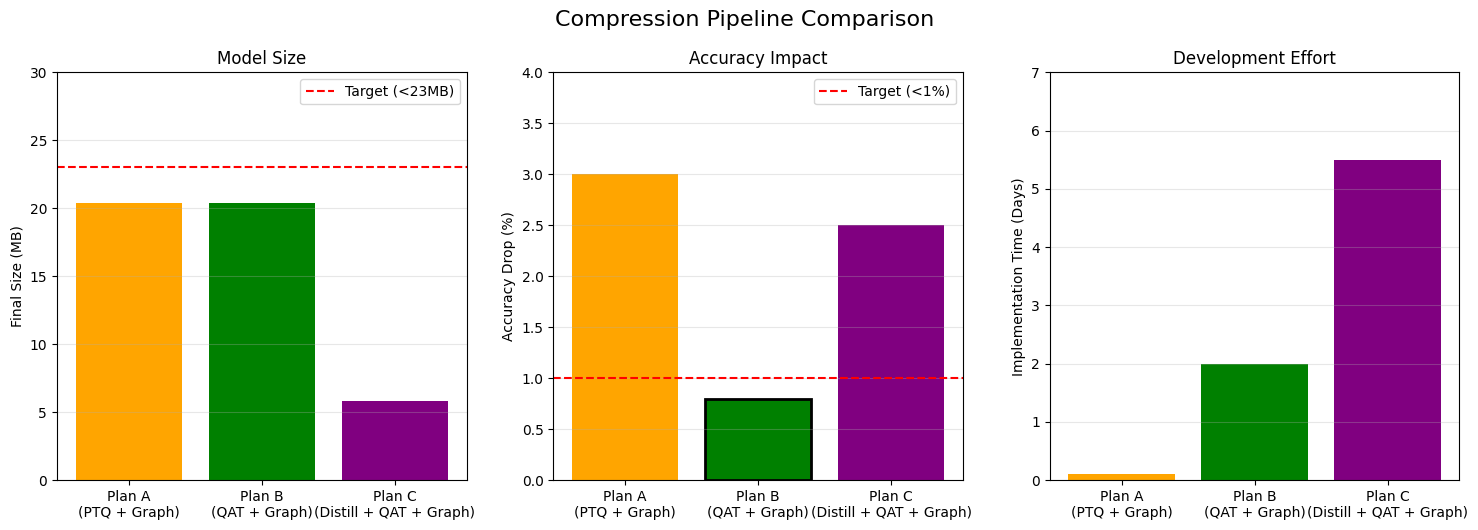

In [15]:
# Create a comparison table
import matplotlib.pyplot as plt
import numpy as np

# Data for comparison
plans = ['Plan A\n(PTQ + Graph)', 'Plan B\n(QAT + Graph)', 'Plan C\n(Distill + QAT + Graph)']
sizes = [20.4, 20.4, 5.8]
accuracy_drops = [3.0, 0.8, 2.5]
implementation_time = [0.1, 2, 5.5]  # in days

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Size comparison
bars1 = ax1.bar(plans, sizes, color=['orange', 'green', 'purple'])
ax1.axhline(y=23, color='r', linestyle='--', label='Target (<23MB)')
ax1.set_ylabel('Final Size (MB)')
ax1.set_title('Model Size')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 30)

# Accuracy drop comparison
bars2 = ax2.bar(plans, accuracy_drops, color=['orange', 'green', 'purple'])
ax2.axhline(y=1, color='r', linestyle='--', label='Target (<1%)')
ax2.set_ylabel('Accuracy Drop (%)')
ax2.set_title('Accuracy Impact')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, 4)

# Implementation time comparison
bars3 = ax3.bar(plans, implementation_time, color=['orange', 'green', 'purple'])
ax3.set_ylabel('Implementation Time (Days)')
ax3.set_title('Development Effort')
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0, 7)

# Highlight which meet requirements
for i, v in enumerate(accuracy_drops):
    if v <= 1:
        bars2[i].set_edgecolor('black')
        bars2[i].set_linewidth(2)

# Add requirements line labels
ax1.legend()
ax2.legend()

plt.tight_layout()
plt.suptitle('Compression Pipeline Comparison', fontsize=16, y=1.05)
plt.show()

> **From plan to action: Implementing pipelines the easy way**: With our pipeline designed, the next step is implementation. In my experience, one important key to successful pipeline implementation is building a modular framework from the start. 
> 
> Rather than hardcoding each compression technique, create swappable components with standardized interfaces. This modular design lets you easily transition between plans (e.g., from PTQ to QAT) if initial results don't meet requirements, conduct controlled experiments to optimize each stage, and reuse the framework for future projects. 
> 
> By investing in this architecture upfront, you transform compression from a one-off effort into a systematic capability that adapts to changing requirements and scales across your ML infrastructure.